<a href="https://colab.research.google.com/github/lanyu0322/pedestrian_firstdraft_figures/blob/master/fig8_fig9_sratio_temp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import statistics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter as uf
from scipy.optimize import least_squares

plt.style.use("bmh")
plt.rcParams.update({
                     "axes.facecolor" : "white",
                     "axes.edgecolor":  "black" })
plt.rcParams["axes.grid"] = False
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Define 4 pop model

In [ ]:
# -- read in the average weekend counts
fname = os.path.join("drive", "My Drive", "lwir", "data", "nycdot", 
                     "avg_weekend_ts.feather")
weekend = uf(pd.read_feather(fname)["avg_counts"].values, 8)

In [ ]:
# -- read temp and humidity data
tname = os.path.join("drive", "My Drive", "lwir", "data", "4_pop_fit", 
                     "temp_humidity.csv")
temp = pd.read_csv(tname)

In [ ]:
# -- define gaussian
def gauss(xarr, x0, sig, scl):
  """ Create a 1D Gaussian """
  
  amp = scl / (sig * np.sqrt(2.0 * np.pi))
  val = -0.5 * ((xarr - x0) / sig)**2
  
  return amp * np.exp(val)


# -- define the model
def pop_model(param, xval):

  # -- determine which model is being used from length of param array
  nparam = len(param)

  # -- 3 population model
  if nparam == 10:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, off = param
    wamp = 0.0

  # -- 4 population model
  elif nparam == 11:
    m1, m2, m3, sd1, sd2, sd3, scl1, scl2, scl3, wamp, off = param

  # -- ill-defined param array
  else:
    print("Nparam must be 10 (3pop) or 11 (4pop) model!")
    return None

  model = gauss(xval, m1, sd1, scl1) + gauss(xval, m2, sd2, scl2) + \
    gauss(xval, m3, sd3, scl3) + wamp * wendvals + off

  return model


# -- define model error
def res(param, xval, yval):

  return yval - pop_model(param, xval)

In [ ]:
# -- set inital guess
avgs  = [35, 47, 70] 
sigs  = [3, 3, 3]
scls  = [5, 5, 5]
off   = [0.5]
wamp = [6]
param = avgs + sigs + scls + wamp + off


# Get time series data for each camera each day

In [ ]:
# -- read multi_files and combine them together
path = r'drive/My Drive/lwir/data/nycdot/counts_wd_cam'
all_files = glob.glob(path + "/*.feather")

li = []

for filename in all_files:

    if ("175" in filename) | ("409" in filename) | ("172" in filename) |\
    ("176" in filename) | ("165" in filename) | ("170" in filename) |\
    ("173" in filename) | ("360" in filename) | ("501" in filename) |\
    ("537" in filename) | ("545" in filename) | ("795" in filename) |\
    ("547" in filename) | ("845" in filename) | ("899" in filename) |\
    ("891" in filename) | ("934" in filename) | ("940" in filename) |\
    ("970" in filename) | ("248" in filename) | ("452" in filename) |\
    ("475" in filename) | ("500" in filename) | ("847" in filename) |\
    ("989" in filename) | ("177" in filename) | ("790" in filename) |\
    ("791" in filename) | ("968" in filename) | ("969" in filename) |\
    ("988" in filename) | ("517" in filename) | ("841" in filename) |\
    ("291" in filename) | ("805" in filename) | ("446" in filename) |\
    ("530" in filename) | ("932" in filename) | ("893" in filename) |\
    ("909" in filename) | ("432" in filename) | ("715" in filename):
      continue

    df = pd.read_feather(filename)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
# -- create day and time column
frame["day"] = frame["date"].dt.date
frame["time"] = frame["date"].dt.time
frame

,date,count,day,time
0,2017-06-28 00:00:00,0.250000,2017-06-28,00:00:00
1,2017-06-28 00:15:00,0.181818,2017-06-28,00:15:00
2,2017-06-28 00:30:00,0.000000,2017-06-28,00:30:00
3,2017-06-28 00:45:00,0.181818,2017-06-28,00:45:00
4,2017-06-28 01:00:00,0.083333,2017-06-28,01:00:00
...,...,...,...,...
342235,2017-09-11 22:45:00,2.000000,2017-09-11,22:45:00
342236,2017-09-11 23:00:00,2.000000,2017-09-11,23:00:00
342237,2017-09-11 23:15:00,2.000000,2017-09-11,23:15:00
342238,2017-09-11 23:30:00,2.000000,2017-09-11,23:30:00


In [ ]:
# -- get available date data
day = frame.groupby("day").count().reset_index()


In [ ]:
# -- groupby day and get the values

fft = frame.groupby("time")

avg_frame = []
for ind, gp in fft:
  avg_frame.append(gp["count"].values)

In [ ]:
# -- replace nans to nearest average counts
avg_frame = pd.DataFrame(avg_frame)
fnan = avg_frame.ffill()
bnan = avg_frame.bfill()
avg_count = 0.5*(fnan + bnan).T

In [ ]:
# -- add date for groupby
def new_sratio(sratio):
  sratio_day = []
  for index, row in sratio.iterrows():
   
    day_index = index % 31
    new_row = []
    new_row.append(row["sratio"])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each sratio
    sratio_day.append(new_row)

  return sratio_day

# 2b. For a given day, standardize each camera and repeat 2a.

In [ ]:
# -- get the counts
avg_2b = avg_count.values.copy()

In [ ]:
# -- standardized data
avg_2b_m = avg_2b.mean(axis=1, keepdims=True)
avg_2b_std = avg_2b.std(axis=1, keepdims=True)
avg_2b_st = (avg_2b - avg_2b_m) / (avg_2b_std + (avg_2b_std == 0))

In [ ]:
# -- build dataframe for st counts
avg_2b_st = pd.DataFrame(avg_2b_st)

In [ ]:
# -- define add date

def add_date(count):
  count_day = []
  for index, row in count.iterrows():
   
    day_index = index % 31
    new_row = []
    for i in range(len(row)):
      new_row.append(row[i])
    new_row.append(day["day"].iloc[day_index]) #add a new sublist to each row
    count_day.append(new_row)

  return count_day

In [ ]:
# -- add date for st counts
avg_2b_date = pd.DataFrame(add_date(avg_2b_st))

In [ ]:
# -- rename dataframe 96 to day
avg_2b_date = avg_2b_date.rename(columns = {96:'day'})

In [ ]:
# -- get avg_st counts
avg_std_date = avg_2b_date.groupby("day").mean()

In [ ]:
# -- optimize
# -- set fit and model parameters and 
wendvals = weekend
xval_final = np.arange(96)
bounds_lo = [24., 44., 64., 2.0, 2.0, 2.0, 0, 0, 0, 0, -np.inf]
bounds_hi = [44., 64., 80., 8., 8., 8., np.inf, np.inf, np.inf, np.inf, np.inf]

plsq_2b = []
for ii in range(len(avg_std_date)):
  #print("working on day {0}".format(ii))

  plsq_2b.append(least_squares(res, param, bounds=(bounds_lo, bounds_hi), 
                            args=(xval_final, avg_std_date.iloc[ii])))

In [ ]:
# -- put fit results into DataFrame
result_2b = pd.DataFrame(plsq_2b)["x"].values
df2b = pd.DataFrame(np.vstack(result_2b), 
                     columns=["m1", "m2", "m3", "sd1", "sd2", "sd3", 
                              "scl1", "scl2", "scl3", "wamp", "off"])

In [ ]:
# -- calculate sratio 
df2b["sratio"] = df2b["scl2"] / (0.5 * (df2b["scl1"] + df2b["scl3"]))

In [ ]:
# -- add date column
sratio_2b = pd.DataFrame(new_sratio(df2b))
sratio_2b["wamp"] = df2b["wamp"]
sratio_2b["scl1"] = df2b["scl1"]
sratio_2b["scl2"] = df2b["scl2"]
sratio_2b["scl3"] = df2b["scl3"]
sratio_2b.columns = ["sratio", "date", "wamp", "scl1", "scl2", "scl3"]
sratio_2b

,sratio,date,wamp,scl1,scl2,scl3
0,0.531690,2017-06-28,0.003348,16.939516,9.003695,16.928664
1,0.327614,2017-06-29,0.004120,15.718412,4.309126,10.587681
2,0.312530,2017-06-30,0.004220,15.312095,3.681111,8.244730
3,0.462118,2017-07-05,0.003376,20.108011,7.805806,13.674731
4,0.382534,2017-07-06,0.003502,21.321369,7.400964,17.373085
5,0.535100,2017-07-10,0.002622,18.755122,11.447974,24.033041
6,0.789747,2017-07-11,0.002542,19.914646,16.092193,20.838133
7,0.378469,2017-07-12,0.003113,19.365021,7.097287,18.140230
8,0.387272,2017-07-13,0.004790,13.340581,2.752967,0.876633
9,0.665788,2017-07-17,0.002658,18.029006,12.493421,19.500733


In [ ]:
# -- subset humidity and temp to our research period
sratio_2b["date"] = sratio_2b["date"].astype(str)
temp_day_2b = sratio_2b.merge(temp, left_on="date", right_on="day")

In [ ]:
temp_day_2b

,sratio,date,wamp,scl1,scl2,scl3,temp,humidity,day,scl1_scl3
0,0.531690,2017-06-28,0.003348,16.939516,9.003695,16.928664,78.1,67.0,2017-06-28,33.868180
1,0.327614,2017-06-29,0.004120,15.718412,4.309126,10.587681,81.0,70.0,2017-06-29,26.306093
2,0.312530,2017-06-30,0.004220,15.312095,3.681111,8.244730,88.0,69.0,2017-06-30,23.556825
3,0.462118,2017-07-05,0.003376,20.108011,7.805806,13.674731,84.9,62.0,2017-07-05,33.782742
4,0.382534,2017-07-06,0.003502,21.321369,7.400964,17.373085,75.0,76.0,2017-07-06,38.694454
5,0.535100,2017-07-10,0.002622,18.755122,11.447974,24.033041,82.9,69.0,2017-07-10,42.788163
6,0.789747,2017-07-11,0.002542,19.914646,16.092193,20.838133,84.0,82.0,2017-07-11,40.752779
7,0.378469,2017-07-12,0.003113,19.365021,7.097287,18.140230,87.1,77.0,2017-07-12,37.505251
8,0.387272,2017-07-13,0.004790,13.340581,2.752967,0.876633,89.1,87.0,2017-07-13,14.217214
9,0.665788,2017-07-17,0.002658,18.029006,12.493421,19.500733,84.9,84.0,2017-07-17,37.529738


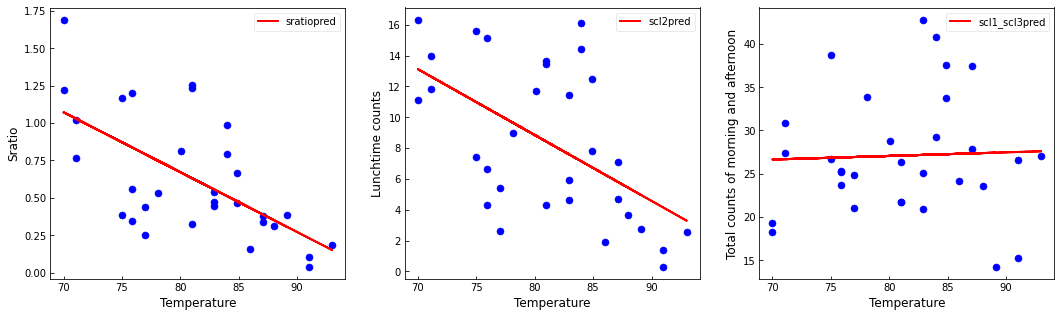

In [ ]:
from matplotlib import gridspec
import statsmodels.formula.api as sm


fig = plt.figure(figsize=(18,5))

spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
sub_2b = temp_day_2b.copy()
sub_2b["sratiopred"] = sm.ols("sratio ~ temp", data=sub_2b).fit().predict(sub_2b)
sub_2b.plot.scatter("temp", "sratio", s=50, ax=ax0)
sub_2b.plot("temp", "sratiopred", c = "r", ax=ax0)

plt.xlabel("Temperature")
plt.ylabel("Sratio")

ax1 = fig.add_subplot(spec[0, 1])
sub_2b["scl2pred"] = sm.ols("scl2 ~ temp", data=sub_2b).fit().predict(sub_2b)
sub_2b.plot.scatter("temp", "scl2", s=50, ax=ax1)
sub_2b.plot("temp", "scl2pred", c = "r", ax=ax1)

plt.ylabel("Lunchtime counts")
plt.xlabel("Temperature")

ax2 = fig.add_subplot(spec[0, 2])
sub_2b_scl1_scl3 = temp_day_2b.copy()
temp_day_2b["scl1_scl3"] = temp_day_2b["scl1"]+temp_day_2b["scl3"]
sub_2b_scl1_scl3 = temp_day_2b.copy()
sub_2b_scl1_scl3["scl1_scl3pred"] = sm.ols("scl1_scl3 ~ temp", data=sub_2b_scl1_scl3).fit().predict(sub_2b_scl1_scl3)
sub_2b_scl1_scl3.plot.scatter("temp", "scl1_scl3", s=50, ax=ax2)
sub_2b_scl1_scl3.plot("temp", "scl1_scl3pred", c = "r", ax=ax2)

plt.ylabel("Total counts of morning and afternoon")
plt.xlabel("Temperature")

outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure8",
                       "sratio_temp.png")
fig.savefig(outfile)

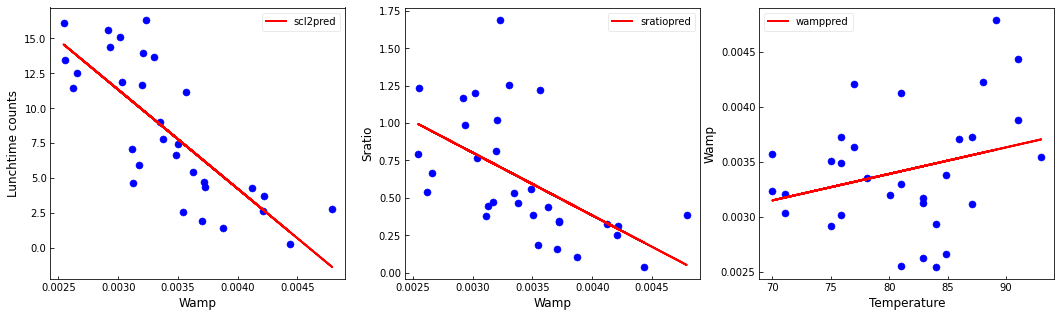

In [ ]:
from matplotlib import gridspec

fig = plt.figure(figsize=(18,5))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
sub_2b_scl2 = temp_day_2b.copy()
sub_2b_scl2["scl2pred"] = sm.ols("scl2 ~ wamp", data=sub_2b_scl2).fit().predict(sub_2b_scl2)
sub_2b_scl2.plot.scatter("wamp", "scl2", s=50, ax=ax0)
sub_2b_scl2.plot("wamp", "scl2pred", c = "r", ax=ax0)
plt.xlabel("Wamp")
plt.ylabel("Lunchtime counts")

ax1 = fig.add_subplot(spec[0, 1])
sub_2b_wamp_s = temp_day_2b.copy()
sub_2b_wamp_s["sratiopred"] = sm.ols("sratio ~ wamp", data=sub_2b_wamp_s).fit().predict(sub_2b_wamp_s)
sub_2b_wamp_s.plot.scatter("wamp", "sratio", s=50, ax=ax1)
sub_2b_wamp_s.plot("wamp", "sratiopred", c = "r", ax=ax1)
plt.xlabel("Wamp")
plt.ylabel("Sratio")


ax2 = fig.add_subplot(spec[0, 2])
sub_2b_wamp_t = temp_day_2b.copy()
sub_2b_wamp_t["wamppred"] = sm.ols("wamp ~ temp", data=sub_2b_wamp_t).fit().predict(sub_2b_wamp_t)
sub_2b_wamp_t.plot.scatter("temp", "wamp", s=50, ax=ax2)
sub_2b_wamp_t.plot("temp", "wamppred", c = "r", ax=ax2)
plt.xlabel("Temperature")
plt.ylabel("Wamp")

outfile = os.path.join("drive", "My Drive", "lwir", "output", "figure9",
                       "sratio_wamp.png")
fig.savefig(outfile)